In [16]:
%load_ext autoreload
%autoreload 2

import sys,os
import torch
import yaml
import logging
import pytorch_lightning as pl
from pydantic import ValidationError

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.CiT.datasets.dataset import ValidationDataset
from models.CiT.training.configs import TrainingConfig
from models.CiT.training.configs import TrainingRunConfig

def get_normal_dataset(config: TrainingConfig):
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    vars = config.air_variable + config.surface_variable + config.only_input_variable + config.constant_variable

    weather = WeatherDataset(config.train_start, config.train_end, device=device, download_variables=vars, download_levels=config.levels)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    
    source, mean_std, var_vocab = weather.load_one(config.air_variable, config.surface_variable, config.only_input_variable, 
                                        config.constant_variable, level=config.levels)
    
    var_list = var_vocab.get_code(vars)
    print(var_list)
    dataset = ValidationDataset(source, var_list, config.time_len, config.max_lead_time)
    return dataset, mean_std, var_list

config_path = os.path.join(os.path.dirname(os.getcwd()), 'configs/train_config.yaml')

try:
    with open(config_path) as f:
        config_dict = yaml.safe_load(f)
    config: TrainingRunConfig = TrainingRunConfig.parse_obj(config_dict)
except FileNotFoundError:
    logging.error(f"Config file {config_path} does not exist. Exiting.")
except yaml.YAMLError:
    logging.error(f"Config file {config_path} is not valid YAML. Exiting.")
except ValidationError as e:
    logging.error(f"Config file {config_path} is not valid. Exiting.\n{e}")
else:
    pl.seed_everything(config.seed)


dataset, mean_std, var_list = get_normal_dataset(config.training)

Seed set to 123


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
데이터셋 불러오는 중...
2013-01-01T00:00:00.000000000
2023-01-01T00:00:00.000000000
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                  (time: 87649, latitude: 36, longitude: 36, level: 8)
Coordinates:
  * latitude                 (latitude) float64 20.04 20.74 ... 43.95 44.65
  * level                    (level) int64 50 100 250 500 600 700 850 925
  * longitude                (longitude) float64 115.3 116.0 ... 139.2 139.9
  * time                     (time) datetime64[ns] 2013-01-01 ... 2023-01-01
Data variables:
    10m_u_component_of_wind  (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    10m_v_component_of_wind  (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    2m_temperature           (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    geopotential           

100%|██████████| 12/12 [00:33<00:00,  2.78s/it]


38.95880 sec
tensor([ 0,  1,  2,  3,  4,  5,  6,  7, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 56, 57, 61, 63, 64])


In [57]:
%load_ext autoreload
%autoreload 2

from models.CiT.training.lightning import TrainModule

model = TrainModule.load_from_checkpoint('/workspace/Haea_dev/models/CiT/tb_logs/lightning_logs/m41ddj8k/checkpoints/epoch=12-step=56966.ckpt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/workspace/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [58]:
from torch.utils.data import DataLoader, Dataset
import tqdm

test_ds, _ = torch.utils.data.random_split(
            dataset,
            [0.3, 0.7],
        )

data_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=4)
results = []
epoch = 1
model.setting()

for i, batch in enumerate(tqdm.tqdm(data_loader)):
        result = model(batch)
        results.append(result)

  0%|          | 0/1095 [00:00<?, ?it/s]

100%|██████████| 1095/1095 [04:03<00:00,  4.49it/s]


In [53]:
errors = []
accs = []
pods = []
for loss, acc, pod in results:
    errors.append(loss)
    print(pod)
    accs.append(acc)
    pods.append(pod)

tensor([[1., 1., 1., 1., 0., 0., nan, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, 0., 0., 0., 0., 0.],
        [1., 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan]], device='cuda:0')
tensor([[1., 1., 1., 1., 1., 1., 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.],
        [1., 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan]], device='cuda:0')
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [46]:
errors = torch.stack(errors, dim=0)
print(errors.shape)
accs = torch.stack(accs, dim=0)
print(accs.shape)
pods = torch.stack(pods, dim=0)
print(pods.shape)

torch.Size([1095, 3, 24, 54])
torch.Size([1095, 3, 24])
torch.Size([1095, 3, 24])


In [47]:
errors = errors.mean(dim=0)
accs = accs.mean(dim=0)
pods = pods.mean(dim=0)
print(errors.shape)
print(accs.shape)
print(pods.shape)

torch.Size([3, 24, 54])
torch.Size([3, 24])
torch.Size([3, 24])


In [49]:
errors = errors.view(-1, errors.size(-1))
accs = accs.view(-1)
pods = pods.view(-1)
print(errors.shape)
print(accs.shape)
print(pods.shape)

torch.Size([72, 54])
torch.Size([72])
torch.Size([72])


In [52]:
print(accs)

tensor([0.9525, 0.9562, 0.9589, 0.9580, 0.9543, 0.9562, 0.9589, 0.9461, 0.9452,
        0.9461, 0.9425, 0.9425, 0.9379, 0.9306, 0.9361, 0.9352, 0.9425, 0.9370,
        0.9425, 0.9406, 0.9397, 0.9406, 0.9361, 0.9498, 0.9452, 0.9434, 0.9479,
        0.9461, 0.9434, 0.9470, 0.9507, 0.9352, 0.9315, 0.9333, 0.9370, 0.9342,
        0.9397, 0.9279, 0.9315, 0.9342, 0.9324, 0.9379, 0.9479, 0.9507, 0.9571,
        0.9580, 0.9452, 0.9416, 0.6447, 0.6265, 0.6155, 0.6155, 0.6384, 0.6648,
        0.6767, 0.6776, 0.6557, 0.6521, 0.6365, 0.6457, 0.6374, 0.6338, 0.6329,
        0.6311, 0.6274, 0.6365, 0.6502, 0.6575, 0.6639, 0.6575, 0.6493, 0.6466],
       device='cuda:0')


In [8]:
output = errors.swapaxes(0, 1)

print(output.shape)

torch.Size([54, 72])


In [9]:
import matplotlib.pyplot as plt

def visualize(loss: torch.Tensor, title, isAIR = False, level=None):
    loss = loss.cpu()
    if isAIR:
        loss = loss.swapaxes(0, 1)
        if level is not None:
            loss = loss[:, level]
        
    print(loss.shape)
    plt.plot(loss, label="rmse loss")
    plt.title(title)
    plt.show()

torch.Size([72])


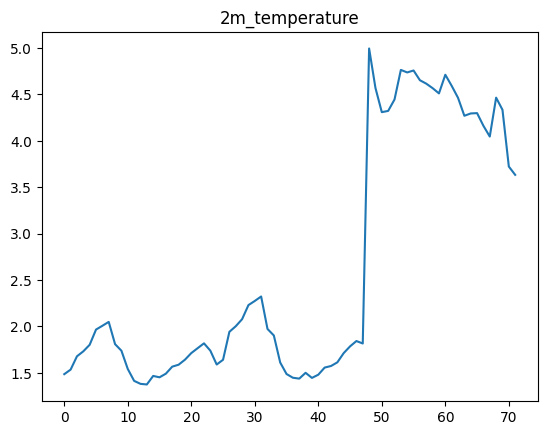

torch.Size([72])


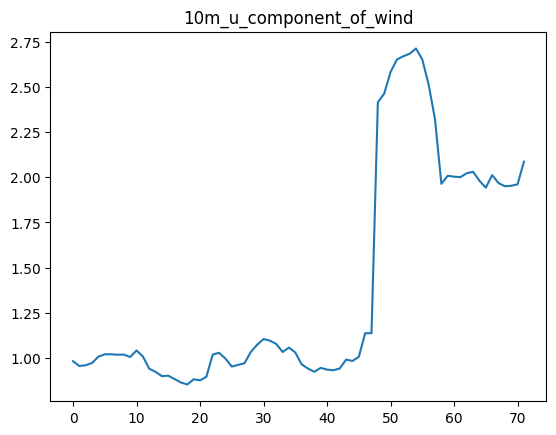

torch.Size([72])


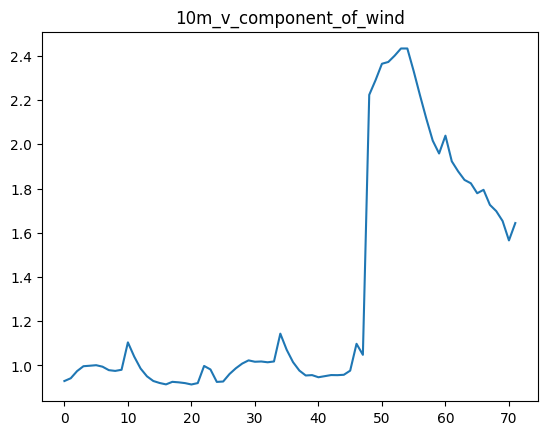

torch.Size([72])


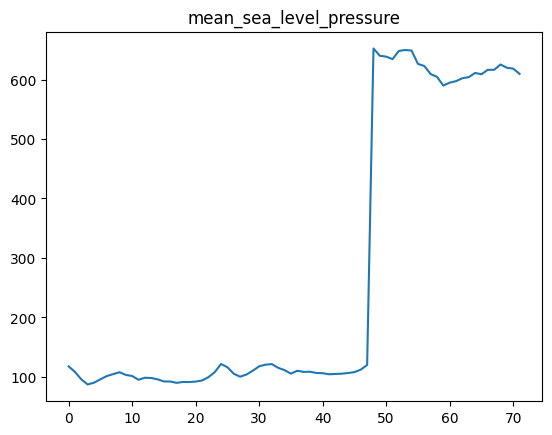

torch.Size([72])


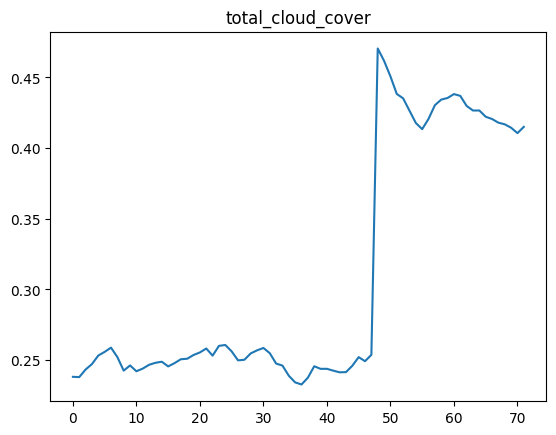

torch.Size([72])


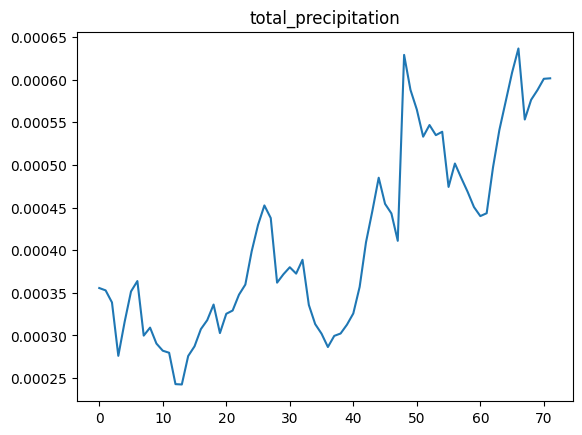

In [13]:
for i, var in enumerate(config.training.surface_variable):
        idx = len(config.training.air_variable) * len(config.training.levels) + i
        visualize(torch.sqrt(output[idx]), var, isAIR=False)

torch.Size([72])


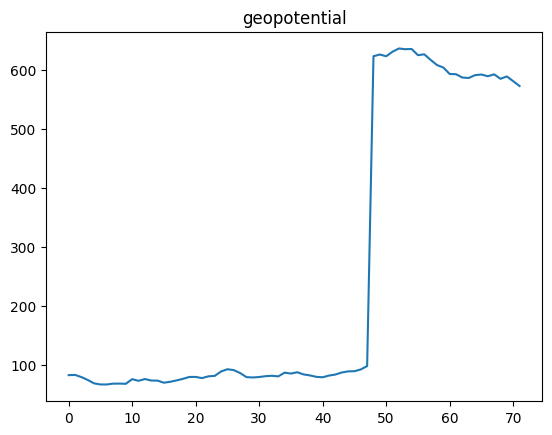

torch.Size([72])


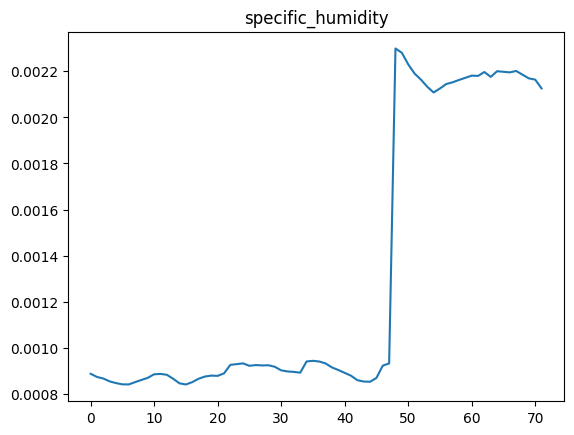

torch.Size([72])


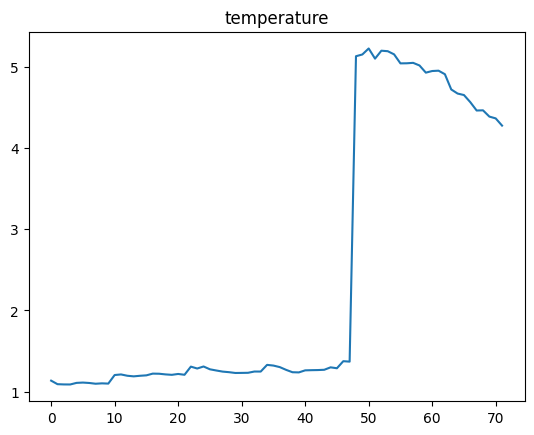

torch.Size([72])


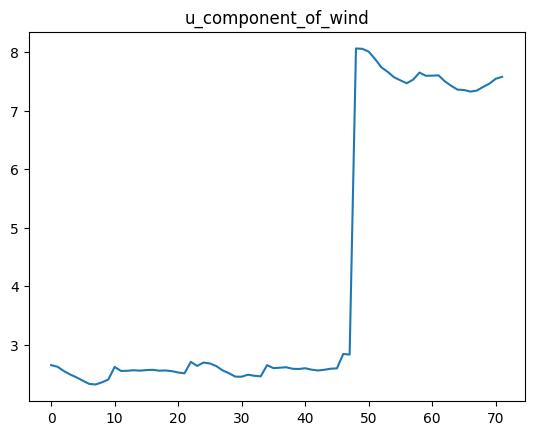

torch.Size([72])


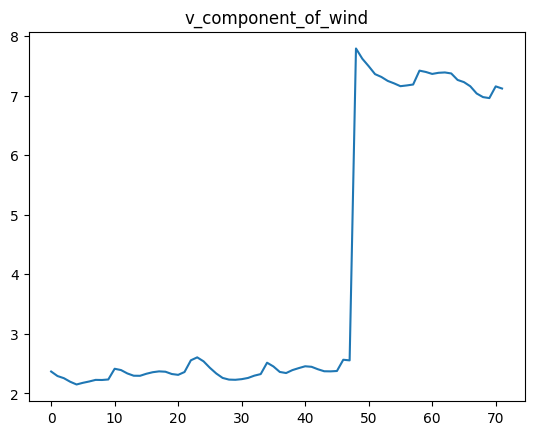

torch.Size([72])


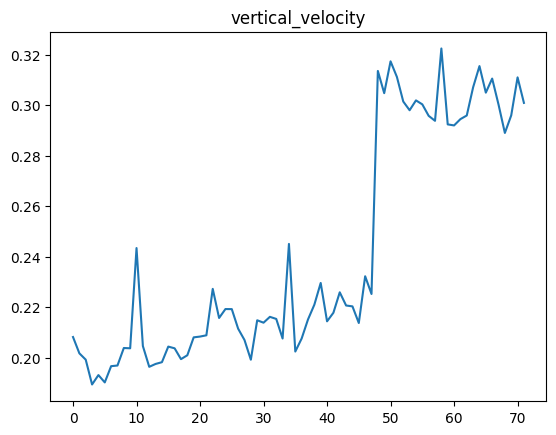

In [11]:
for idx, var in enumerate(config.training.air_variable):
        air_list = [ ((idx)*len(config.training.levels)) + i for i in range(len(config.training.levels))]
        visualize(torch.sqrt(output[air_list]), var, isAIR=True, level=-3)